In [1]:
import numpy as np 
import pandas as pd 
import zipfile
import tensorflow as tf


In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [3]:
import matplotlib as plt
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, Conv2D,MaxPooling2D,BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.metrics import categorical_crossentropy
from sklearn.metrics import confusion_matrix

In [4]:
with zipfile.ZipFile('AI_final.zip', 'r') as z:
    z.extractall('AI_final')

In [5]:
filenames = os.listdir("./AI_final/emotion_images/")
categories = []
for image in filenames :
    category = image.split('.')[0]
    if category == 'happy' :
        categories.append(1)
    elif category == 'disgust' :
        categories.append(2)
    elif category == 'fear' :
        categories.append(3)
    elif category == 'angry' :
        categories.append(4)
    elif category == 'neutral' :
        categories.append(5)
    elif category == 'sad' :
        categories.append(6)
    else : 
        categories.append(0)

In [6]:
df = pd.DataFrame({'filename' : filenames, 'category' : categories})
df.head()

,filename,category
0,angry,4
1,disgust,2
2,fear,3
3,happy,1
4,neutral,5


In [7]:
df['category'].value_counts()

0    2
4    1
2    1
3    1
1    1
5    1
6    1
Name: category, dtype: int64

In [46]:
#for i in range(10) :
    #sample = filenames[i]
    #image = tf.keras.preprocessing.image.load_img('./AI_final/emotion_images/' + sample)
    #plt.imshow(image)
    #plt.title('happy' if categories[i+10]==1 else 'sad')
    #plt.show()

PermissionError: [Errno 13] Permission denied: './AI_final/emotion_images/angry'

In [8]:
BATCH_SIZE = 128

def create_model(x=None):
    # we initialize the model
    model = Sequential()

    # Conv Block 1
    model.add(Conv2D(64, (3, 3), input_shape=(48,48,3),  padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3),   padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3),  padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # Conv Block 2
    model.add(Conv2D(128, (3, 3),  padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(128, (3, 3),  padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(128, (3, 3),  padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # Conv Block 3
    model.add(Conv2D(256, (3, 3),  padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
   
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # Conv Block 4
    model.add(Conv2D(512, (3, 3),  padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
   
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # Conv Block 5
    model.add(Conv2D(512, (3, 3),  padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
   
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(3, 3)))


    # FC layers
    model.add(Flatten())
    model.add(Dropout(0.5))
    
    model.add(Dense(7, activation='softmax'))

    return model

model = create_model()

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 64)        1792      
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 64)        36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 48, 64)        256       
_________________________________________________________________
activation_1 (Activation)    (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 48, 64)        3

In [9]:
def image_data_generator(data_dir,
                         data_augment=False,
                         batch_size=BATCH_SIZE,
                         target_size=(48, 48),
                         color_mode='rgb',
                         class_mode='categorical',
                         shuffle=True):
    if data_augment:
        datagen = ImageDataGenerator(rescale=1./255,
                                     rotation_range=20,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     shear_range=0.2,
                                     zoom_range=0.2,
                                     horizontal_flip=True)
    else:
        datagen = ImageDataGenerator(rescale=1./255)

    generator = datagen.flow_from_directory(data_dir,
                                            target_size=target_size,
                                            color_mode=color_mode,
                                            batch_size=batch_size,
                                            shuffle=shuffle,
                                            class_mode=class_mode)
    return generator

In [10]:
train_generator = image_data_generator('/Users/fiona/AI/AI_final/MMAFEDB/train',data_augment=True)
validation_generator = image_data_generator('/Users/fiona/AI/AI_final/MMAFEDB/valid')

Found 92968 images belonging to 7 classes.
Found 17356 images belonging to 7 classes.


In [11]:
model.compile(Adam(lr=0.001),loss="categorical_crossentropy",metrics=["accuracy"])

C:\Users\fiona\Downloads\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [12]:
import tensorflow.keras
callbacks_list = [
tensorflow.keras.callbacks.EarlyStopping(
monitor='val_accuracy', min_delta=0.0001, 
patience=10, verbose=1, mode='auto',
baseline=None, restore_best_weights=True),
tensorflow.keras.callbacks.ReduceLROnPlateau(
monitor='val_accuracy',
factor=0.5,
patience=5,
verbose=1,
mode='auto')]

In [13]:
history = model.fit_generator(train_generator,steps_per_epoch=92968//BATCH_SIZE,epochs=30,
                              validation_data=validation_generator,
                              validation_steps=17356//BATCH_SIZE,callbacks=callbacks_list)


C:\Users\fiona\Downloads\lib\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
726/726 [==============================] - 3770s 5s/step - loss: 1.8049 - accuracy: 0.3373 - val_loss: 1.6762 - val_accuracy: 0.3387
Epoch 2/30
726/726 [==============================] - 3523s 5s/step - loss: 1.5261 - accuracy: 0.4358 - val_loss: 1.7088 - val_accuracy: 0.3775
Epoch 3/30
726/726 [==============================] - 3530s 5s/step - loss: 1.2326 - accuracy: 0.5686 - val_loss: 1.4683 - val_accuracy: 0.4805
Epoch 4/30
726/726 [==============================] - 3534s 5s/step - loss: 1.1103 - accuracy: 0.6134 - val_loss: 1.3620 - val_accuracy: 0.5228
Epoch 5/30
726/726 [==============================] - 3517s 5s/step - loss: 1.0562 - accuracy: 0.6324 - val_loss: 1.4187 - val_accuracy: 0.4943
Epoch 6/30
726/726 [==============================] - 3516s 5s/step - loss: 1.0201 - accuracy: 0.6460 - val_loss: 1.2429 - val_accuracy: 0.5586
Epoch 7/30
726/726 [==============================] - 3518s 5s/step - loss: 0.9891 - accuracy: 0.6558 - val_loss: 1.3996 - val_accuracy:

In [14]:
def evaluate_model(model=None, filepath=None):
    """return the evaluate """
    if not model:
        assert(filepath)
        model = models.load_model(filepath)
    test_generator = image_data_generator('/Users/fiona/AI/AI_final/MMAFEDB/test', batch_size=1, shuffle=False)

    nb_samples = len(test_generator)
    score = model.evaluate_generator(test_generator, steps=nb_samples)
    print(score)
    return score

In [15]:
score = evaluate_model(model)

Found 17356 images belonging to 7 classes.


C:\Users\fiona\Downloads\lib\site-packages\keras\engine\training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


[1.0805546045303345, 0.6292924880981445]


In [16]:
model.save_weights("emotion_classifier.h5")

In [17]:
from matplotlib import pyplot as plt

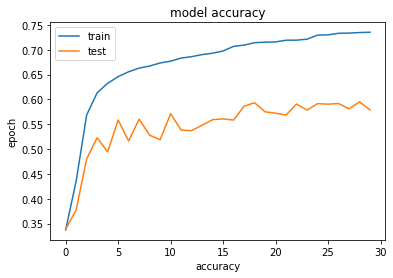

In [18]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.xlabel('accuracy')
plt.ylabel('epoch')
plt.legend(['train','test'],loc='upper left')
plt.show()


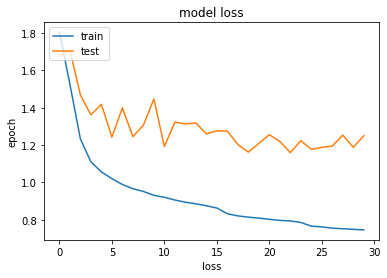

In [19]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.xlabel('loss')
plt.ylabel('epoch')
plt.legend(['train','test'],loc='upper left')
plt.show()